# MIRI PSF Photometry #3 - Create your first MIRI Color-Magnitude Diagram

**Author**: Ori Fox
<br>
**Last Updated**: March, 2022

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<br>
    2.1 [Python imports](#py_imports)<br>
    2.2 [Plotting functions imports](#matpl_imports)<br>
    2.3 [PSF FWHM dictionary](#psf_fwhm)<br>
3. [Import image to analyze](#data)<br>
4. [Create your first MIRI Color-Magnitude Diagram](#bonusI)<br>
    4.1 [Load images and output catalogs](#load_data)<br>
    4.2 [Cross-match PSF photometry catalogs](#cross_match)<br>
    4.3 [Load input catalogs](#load_input)<br>
    4.4 [Cross-match input catalogs](#cross_match_input)<br>
    4.5 [Instrumental Color-Magnitude Diagram](#cmd)<br>

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Data**: MIRI simulated images obtained using [MIRISIM](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of Isochrone of 10-Gyr old population, [Fe/H]=-1 Population placed at 2.5 kpc from the Sun. Salpeter-like IMF, tweaked to have more massive stars (since positions are random, it ensures at least a few bright stars in each image). Kept only sources brighter than J=17 (random cut to speed up MIRISim) and fainter than Ks=10 (to avoid too-bright stars that would have PSF spikes clearly cut by MIRISim in the image)

Here is the [ReadMe](https://stsci.app.box.com/s/2b6evrie2swaybarxhdmpqizktl3g0wm/file/869444882607). All data simulations can be found on [STScI's simulation page](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/simulated-data).

PSF Photometry can be obtained using:

* single PSF model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)
* grid of effective PSF (bonus part II)

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images (bonus part I)

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In this section we import all the necessary python packages and we define some plotting parameters.

### 2.1<font color='white'>-</font>Python imports<a class="anchor" id="py_imports"></a> ###

In [1]:
import os

if not os.environ.get('WEBBPSF_PATH'):
    os.environ['WEBBPSF_PATH'] = '/data/webbpsf-data'

import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import urllib.request

import tarfile

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

import jwst
from jwst.datamodels import ImageModel

import webbpsf
from webbpsf.utils import to_griddedpsfmodel

import pysynphot  # PYSIN_CDBS must be defined in the user's environment (see note below)

from collections import OrderedDict
from astropy.wcs import WCS

In [2]:
#
# General tools
#
import glob
import os
import shutil
import sys
import random
import urllib
import zipfile
#
# Astropy tools
#
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy.io import fits, ascii
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table, Column, vstack
import astropy.units as u
from astropy.visualization import LogStretch, LinearStretch, PercentileInterval, ManualInterval
from astropy.nddata import Cutout2D
#
# JWST models
#
from jwst import datamodels, associations
from jwst.datamodels import ImageModel, dqflags
#
# Matplotlib tools
#
from matplotlib import style, pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
#
# Numpy library
#
import numpy as np
#
# Photutils library and tools
#
import photutils
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils import Background2D, MedianBackground, ModeEstimatorBackground, MMMBackground
#
# Scipy tools
#
from scipy import stats
from scipy.interpolate import CubicSpline
#
# Use 90% of the window width
#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

2022-04-15 04:32:35,625 - stpipe - WARNING - /var/folders/yh/kl4y3s1x3_j3ywy3qq67g3vc0001kc/T/ipykernel_64266/2969300567.py:51: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



### 2.2<font color='white'>-</font>Plotting function imports<a class="anchor" id="matpl_imports"></a> ###

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [4]:
%matplotlib inline
# Figure size
plt.rcParams['figure.figsize'] = [15, 15]
# Figure text and font
plt.rc('text', usetex=True)
plt.rc('font', size=15)

### 2.4 Useful Definitions

In [5]:
def arcsec2pix(x):
    '''
    Function that converts arcsec in MIRIM pixels.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in arcsec.
        
    Outputs
    ----------
    The value(s) in MIRIM pixel.
    '''
    
    return x/0.11

In [6]:
def pix2arcsec(x):
    '''
    Function that converts MIRIM pixels in arcsec.
    It is used to setup the secondary axes in a plot.
    
    Inputs
    ----------
    x : float or array(float)
        The value in MIRIM pixels.
        
    Outputs
    ----------
    The value(s) in arcsec.
    '''
    
    return x*0.11

In [7]:
folder_path = './data/'
filter_names = ['F560W', 'F770W']

img_names = {}
cat_names = {}
for f in filter_names:
    print('')
    print(r'{0}-filter images:'.format(f))
    names = glob.glob(folder_path + 'det_*' + f + '*_cal.fits')
    for n in range(len(names)):
        print(r'     {0}) {1}'.format(n+1, names[n]))
    img_names[f] = names
    names = glob.glob(folder_path + 'complex_*' + f + '*cat*.ecsv')
    cat_names[f] = names
    print('')
    print(r'1 catalog found: {0}'.format(names[0]))


F560W-filter images:
     1) ./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits
     2) ./data/det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits
     3) ./data/det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits
     4) ./data/det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F560W_combined_cat.ecsv

F770W-filter images:
     1) ./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits
     2) ./data/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits
     3) ./data/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits
     4) ./data/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits

1 catalog found: ./data/complex_scene_F770W_combined_cat.ecsv


**Note**: in this particular example, we analyze each image separately to provide a general overview of the different steps necessary to perform PSF photometry and to highlight the different functions adopted in this notebook.

3.<font color='white'>-</font>Create your first NIRCam Color-Magnitude Diagram<a class="anchor" id="bonusI"></a>
------------------

### 3.1<font color='white'>-</font>Load images and output catalogs<a class="anchor" id="load_data"></a> ###

In [8]:
if os.path.isfile('./PHOT_OUTPUT/phot_MIRIM_F560W.pkl'):
    phot_f560w = './PHOT_OUTPUT/phot_MIRIM_F560W.pkl'

#else:
#    print('Downloading F115W PSF photometry')
#    
#    boxlink_ph_f115w = 'https://stsci.box.com/shared/static/f4s4ziwh7tb3827g0ac362swwta28lti.pkl'
#    boxfile_ph_f115w = './phot_webbpsf_grid16_NRCB1_F115W.pkl'
#    urllib.request.urlretrieve(boxlink_ph_f115w, boxfile_ph_f115w)
#    phot_f115w = boxfile_ph_f115w
#
if os.path.isfile('./PHOT_OUTPUT/phot_MIRIM_F770W.pkl'):
    phot_f770w = './PHOT_OUTPUT/phot_MIRIM_F770W.pkl'

#else:
#    print('Downloading F200W PSF Photometry')
#    
#    boxlink_ph_f200w = 'https://stsci.box.com/shared/static/983dxnxqz594ogn00e6m7ek7vq22gifr.pkl'
#    boxfile_ph_f200w = './phot_webbpsf_grid16_NRCB1_F200W.pkl'
#    urllib.request.urlretrieve(boxlink_ph_f200w, boxfile_ph_f200w)
#    phot_f200w = boxfile_ph_f200w

ph_f560w = pd.read_pickle(phot_f560w)
ph_f770w = pd.read_pickle(phot_f770w)

results_f560w = QTable.from_pandas(ph_f560w)
results_f770w = QTable.from_pandas(ph_f770w)

image_f560w = ImageModel('./data/det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits')
image_f770w = ImageModel('./data/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits')

### 3.2<font color='white'>-</font>Cross-match PSF photometry catalogs<a class="anchor" id="cross_match"></a> ###

We select only stars with positive flux and we use the information from the image WCS to transform detector coordinates (x,y) to celestial coordinate (RA,Dec). 

We use the [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) class and the [match_coordinates_sky](https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html) function to finds the nearest on-sky matches between the set of catalog coordinates.

We impose that a star is the same in both catalogs if the separation is < than `max_sep`, where `max_sep` is 0.015 arcsec (i.e., 0.5 px). 

In [9]:
mask_f560w = ((results_f560w['x_fit'] > 0) & (results_f560w['x_fit'] < 2048) & 
              (results_f560w['y_fit'] > 0) & (results_f560w['y_fit'] < 2048) & 
              (results_f560w['flux_fit'] > 0))

result_clean_f560w = results_f560w[mask_f560w]

ra_f560w, dec_f560w = image_f560w.meta.wcs(result_clean_f560w['x_fit'], result_clean_f560w['y_fit'])
radec_f560w = SkyCoord(ra_f560w, dec_f560w, unit='deg')
result_clean_f560w['radec'] = radec_f560w

mask_f770w = ((results_f770w['x_fit'] > 0) & (results_f770w['x_fit'] < 2048) & 
              (results_f770w['y_fit'] > 0) & (results_f770w['y_fit'] < 2048) & 
              (results_f770w['flux_fit'] > 0))

result_clean_f770w = results_f770w[mask_f770w]

ra_f770w, dec_f770w = image_f770w.meta.wcs(result_clean_f770w['x_fit'], result_clean_f770w['y_fit'])
radec_f770w = SkyCoord(ra_f770w, dec_f770w, unit='deg')
result_clean_f770w['radec'] = radec_f770w

In [10]:
#Clean up array with NANs

res1 = result_clean_f560w
res2 = result_clean_f770w

clean1 = (~np.isnan(res1['radec'].ra) & ~np.isnan(res1['radec'].dec))
res1 = res1[clean1]

clean2 = (~np.isnan(res2['radec'].ra) & ~np.isnan(res2['radec'].dec))
res2 = res2[clean2]

In [11]:
max_sep = 0.12 * u.arcsec #1/2 FWHM https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-predicted-performance/miri-point-spread-functions

filt1 = 'F560W'
filt2 = 'F770W'

#res1 = result_clean_f560w
#res2 = result_clean_f770w

idx, d2d, _ = match_coordinates_sky(res1['radec'], res2['radec'])

sep_constraint = d2d < max_sep

match_phot_single = Table()

x_0_F560W = res1['x_0'][sep_constraint]
y_0_F560W = res1['y_0'][sep_constraint]
x_fit_F560W = res1['x_fit'][sep_constraint]
y_fit_F560W = res1['y_fit'][sep_constraint]
radec_F560W = res1['radec'][sep_constraint]
mag_F560W = (-2.5 * np.log10(res1['flux_fit']))[sep_constraint]
emag_F560W = (1.086 * (res1['flux_unc'] / res1['flux_fit']))[sep_constraint]

x_0_F770W = res2['x_0'][idx[sep_constraint]]
y_0_F770W = res2['y_0'][idx[sep_constraint]]
x_fit_F770W = res2['x_fit'][idx[sep_constraint]]
y_fit_F770W = res2['y_fit'][idx[sep_constraint]]
radec_F770W = res2['radec'][idx][sep_constraint]
mag_F770W = (-2.5 * np.log10(res2['flux_fit']))[idx[sep_constraint]]
emag_F770W = (1.086 * (res2['flux_unc'] / res2['flux_fit']))[idx[sep_constraint]]

match_phot_single['x_0_' + filt1] = x_0_F560W
match_phot_single['y_0_' + filt1] = y_0_F560W
match_phot_single['x_fit_' + filt1] = x_fit_F560W
match_phot_single['y_fit_' + filt1] = y_fit_F560W
match_phot_single['radec_' + filt1] = radec_F560W
match_phot_single['mag_' + filt1] = mag_F560W
match_phot_single['emag_' + filt1] = emag_F560W
match_phot_single['x_0_' + filt2] = x_0_F770W
match_phot_single['y_0_' + filt2] = y_0_F770W
match_phot_single['x_fit_' + filt2] = x_fit_F770W
match_phot_single['y_fit_' + filt2] = y_fit_F770W
match_phot_single['radec_' + filt2] = radec_F770W
match_phot_single['mag_' + filt2] = mag_F770W
match_phot_single['emag_' + filt2] = emag_F770W

print('Number of sources in common between the two filters:', len(match_phot_single)) 

Number of sources in common between the two filters: 634


In [12]:
match_phot_single

x_0_F560W,y_0_F560W,x_fit_F560W,y_fit_F560W,radec_F560W,mag_F560W,emag_F560W,x_0_F770W,y_0_F770W,x_fit_F770W,y_fit_F770W,radec_F770W,mag_F770W,emag_F770W
,,,,"deg,deg",,,,,,,"deg,deg",,
float64,float64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,SkyCoord,float64,float64
676.5836845232664,9.163203068674463,676.4528033510454,9.143528481412565,"359.99881352456674,-0.014224790099242605",-3.6247192938319985,--,700.7268368487117,51.200209611193216,700.7426990170064,51.19501857408793,"359.99881318489224,-0.014224305538111685",-3.017265300487089,0.01168079348154252
459.6132722939766,9.691107008194399,459.4676254402394,9.731651409633358,"0.005474916880854635,-0.014753095154693033",-2.3578271493274725,--,483.77268644197835,51.78890389392475,483.7721978486275,51.79416704114516,"0.005474309053244533,-0.01475256682287582",-1.7976451863359788,0.0437156086603468
597.8626156063478,10.034554224274997,597.8924869050276,10.024051176661084,"0.0012269544870713229,-0.014397581798466239",-1.883371096101567,--,622.1808613066509,52.08991285675754,622.1904939952807,52.080926115506124,"0.0012264277528894103,-0.014396498089267221",-1.483420954341303,0.03934135260740051
990.355083962455,11.901328381398988,990.5259042677674,11.902231407148946,"359.98918858909406,-0.013327033658767059",-3.4967219457768532,--,1014.7905953330403,54.088364493956924,1014.7986248918583,54.0829677605552,"359.98918868778736,-0.013327713196303395",-2.891577511533115,0.14776121101888046
650.2394114200912,13.774477721372348,650.4852259147158,13.796740454764276,"359.99962218949463,-0.014151616057245929",-1.142675090397894,--,674.5955305412729,55.749351720711424,674.6217582090027,55.70800618276585,"359.99962632177505,-0.014154860750673435",-0.8153488497926941,0.053841022673539664
616.4436194942315,16.524752611137632,616.3784387204488,16.42786497276886,"0.0006756530266426701,-0.014159241881793407",-4.7313386437349,--,640.5479783530177,58.44457518525087,640.5241445601326,58.44734062865891,"0.0006798395500667964,-0.01415867759704948",-3.975239859133401,0.0022800710738686385
984.4233392708408,23.31469352825253,984.3566313741701,23.2592861142545,"359.9894055860373,-0.013005494222112321",-2.7372841730532955,--,1008.4294708824649,65.78940191969643,1008.4257055144952,65.76883834191531,"359.98941323835464,-0.012995016972013633",-3.079839392760902,0.010649757859916755
755.2438204968485,19.83530814102132,755.2355827127475,19.84258842868869,"359.9964227358253,-0.01370351772248289",-0.8317151210038358,--,779.047113070801,61.78964753379104,779.1078774366891,61.879731839249814,"359.9964354480205,-0.01370362656810686",-0.13805845628075047,1.8537876540689475


### 3.3<font color='white'>-</font>Photometric Calibration<a class="anchor" id="wcs"></a> ###



In [13]:
calib_cat_F560W = Table.read(cat_names['F560W'][0])
calib_cat_F560W.pprint_all(max_lines=1, max_width=200)
calib_cat_F770W = Table.read(cat_names['F770W'][0])
calib_cat_F770W.pprint_all(max_lines=1, max_width=200)

label xcentroid ycentroid                sky_centroid                ...                sky_bbox_ul                                sky_bbox_lr                               sky_bbox_ur               
                                           deg,deg                   ...                  deg,deg                                    deg,deg                                   deg,deg                 
----- --------- --------- ------------------------------------------ ... ------------------------------------------ ----------------------------------------- -----------------------------------------
    1  757.7435   31.3451    359.99836120500316,-0.01737844736582643 ... 0.003246972520384926,-0.016720884313430235    359.9947473963536,-0.01779814721966357   359.9949061661661,-0.015988928352511637
  ...       ...       ...                                        ... ...                                        ...                                       ...                                       ...


For the cross-match of these catalogs, we can use [_match_coordinates_sky_](https://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs). This function uses a proximity-based approach to find the same star in two catalogs. It requires coordinates to be stored as [_SkyCoord_](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord) objects.

In [14]:
coord_cal = SkyCoord(ra=match_phot_single['radec_F560W'][:].ra, dec=match_phot_single['radec_F560W'][:].dec, unit="deg")
coord_i2d = SkyCoord(ra=calib_cat_F560W['sky_centroid'].ra.degree, dec=calib_cat_F560W['sky_centroid'].dec.degree, unit="deg")
ind_i2d_cat, dist_2d, _ = match_coordinates_sky(coord_cal, coord_i2d)

The first output _ind_i2d_cat_ is an array containing the indexes of the stars in the pipeline source catalog that are the closest objects to each source in our F560W-filter catalog. The second output _dist_2d_ is an array with the on-sky distances between sources. We do not need to save the last output because it corresponds to an array of 3D distances between sources. We do not need it here.

Being based just on proximity, this algorithm can present some issues in very crowded environments. It is always a good idea to check the result of the cross-match:

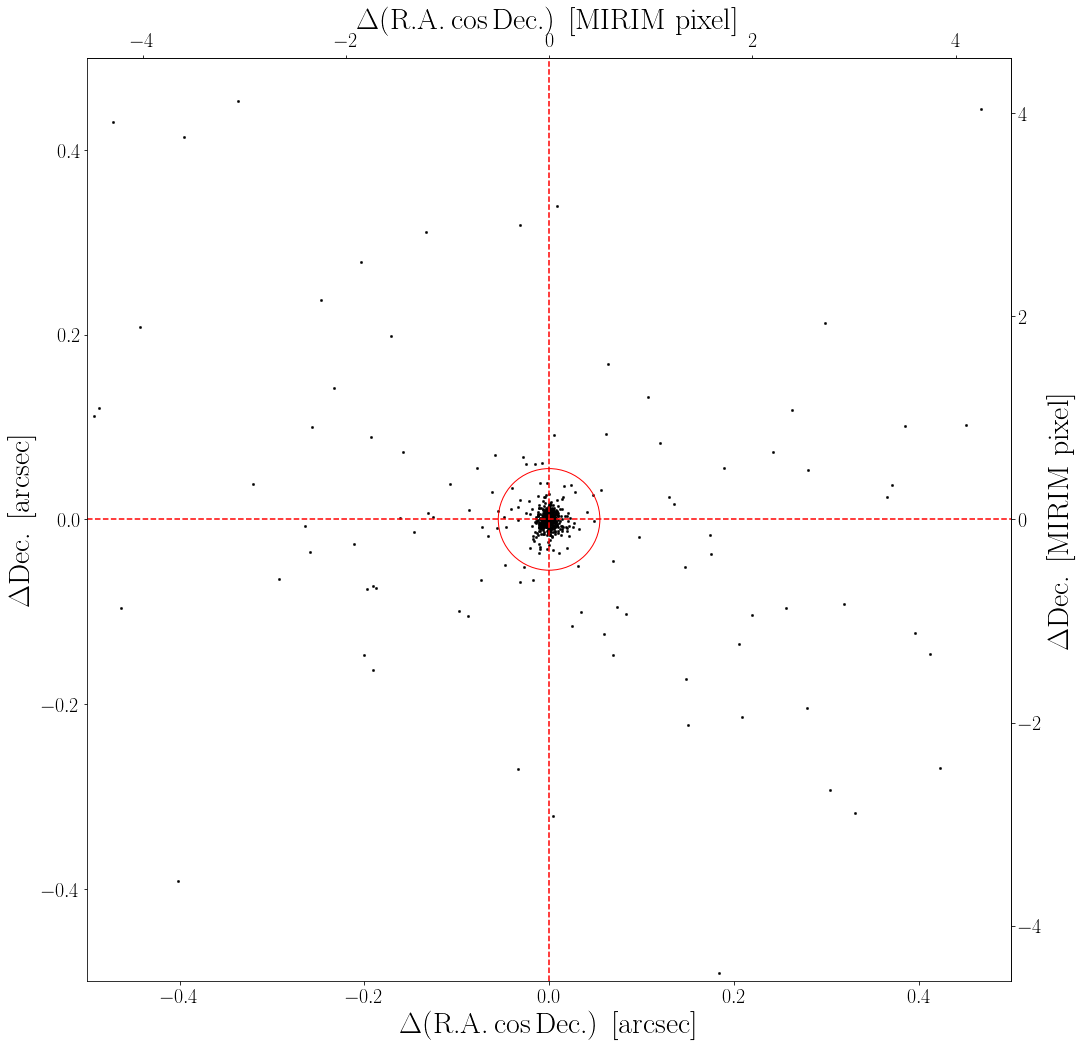

In [15]:
delta_ra = 3600.0*(match_phot_single['radec_F560W'][:].ra.degree*np.cos(np.deg2rad(match_phot_single['radec_F560W'][:].dec.degree)) - 
                   calib_cat_F560W[ind_i2d_cat]['sky_centroid'].ra.degree*np.cos(np.deg2rad(calib_cat_F560W[ind_i2d_cat]['sky_centroid'].dec.degree)))

delta_dec = 3600.0*(match_phot_single['radec_F560W'][:].dec.degree - calib_cat_F560W[ind_i2d_cat]['sky_centroid'].dec.degree)

fig, ax = plt.subplots()
ax.scatter(delta_ra, delta_dec, lw=0.5, s=5, color='black', marker='o')
circle = plt.Circle((0, 0), 0.055, color='r', fill=False)
ax.add_patch(circle)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.axhline(0, color='red', ls='--')
ax.axvline(0, color='red', ls='--')
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [arcsec]}$')
ax.set_ylabel(r'$\Delta\textrm{Dec. [arcsec]}$')

ax2 = ax.secondary_xaxis('top', functions=(arcsec2pix, pix2arcsec))
ax2.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [MIRIM pixel]}$')
ay2 = ax.secondary_yaxis('right', functions=(arcsec2pix, pix2arcsec))
ay2.set_ylabel(r'$\Delta\textrm{Dec. [MIRIM pixel]}$')

plt.tight_layout()

In [16]:
phot_F560W_matched = match_phot_single[dist_2d.arcsec/0.11 < 0.5]
calib_cat_F560W_matched = calib_cat_F560W[ind_i2d_cat[dist_2d.arcsec/0.11 < 0.5]]

In [17]:
coord_cal = SkyCoord(ra=match_phot_single['radec_F770W'][:].ra, dec=match_phot_single['radec_F770W'][:].dec, unit="deg")
coord_i2d = SkyCoord(ra=calib_cat_F770W['sky_centroid'].ra.degree, dec=calib_cat_F770W['sky_centroid'].dec.degree, unit="deg")
ind_i2d_cat, dist_2d, _ = match_coordinates_sky(coord_cal, coord_i2d)

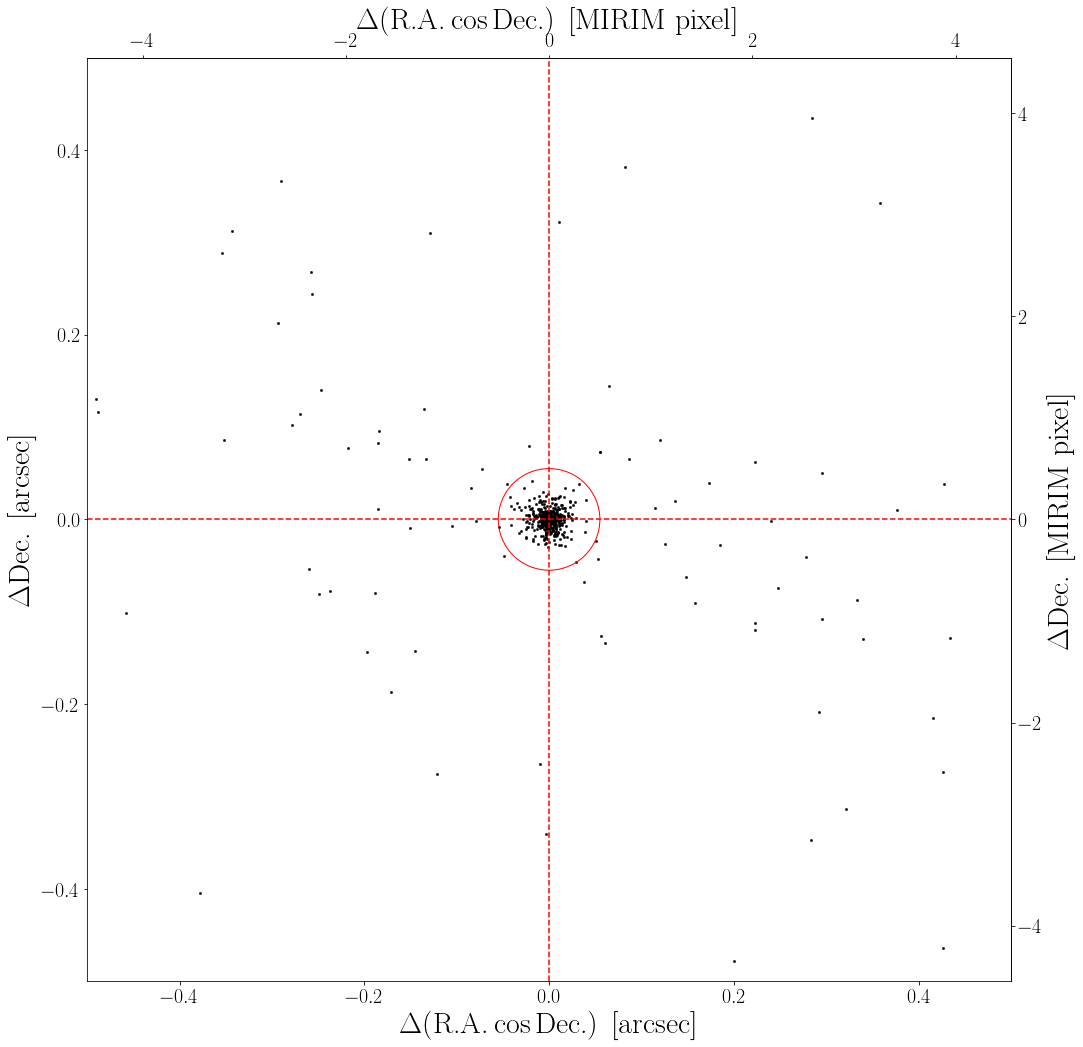

In [18]:
delta_ra = 3600.0*(match_phot_single['radec_F770W'][:].ra.degree*np.cos(np.deg2rad(match_phot_single['radec_F770W'][:].dec.degree)) - 
                   calib_cat_F770W[ind_i2d_cat]['sky_centroid'].ra.degree*np.cos(np.deg2rad(calib_cat_F770W[ind_i2d_cat]['sky_centroid'].dec.degree)))

delta_dec = 3600.0*(match_phot_single['radec_F770W'][:].dec.degree - calib_cat_F770W[ind_i2d_cat]['sky_centroid'].dec.degree)

fig, ax = plt.subplots()
ax.scatter(delta_ra, delta_dec, lw=0.5, s=5, color='black', marker='o')
circle = plt.Circle((0, 0), 0.055, color='r', fill=False)
ax.add_patch(circle)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.axhline(0, color='red', ls='--')
ax.axvline(0, color='red', ls='--')
ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [arcsec]}$')
ax.set_ylabel(r'$\Delta\textrm{Dec. [arcsec]}$')

ax2 = ax.secondary_xaxis('top', functions=(arcsec2pix, pix2arcsec))
ax2.set_xlabel(r'$\Delta\textrm{(R.A.}\cos\textrm{Dec.) [MIRIM pixel]}$')
ay2 = ax.secondary_yaxis('right', functions=(arcsec2pix, pix2arcsec))
ay2.set_ylabel(r'$\Delta\textrm{Dec. [MIRIM pixel]}$')

plt.tight_layout()

Let's define as "found" only objects with a positional rms lower than 0.5 MIRIM pixel, i.e., 0.055 arcsec.

In [19]:
phot_F770W_matched = match_phot_single[dist_2d.arcsec/0.11 < 0.5]
calib_cat_F770W_matched = calib_cat_F770W[ind_i2d_cat[dist_2d.arcsec/0.11 < 0.5]]

Next, we need to compute the zero-point between the magnitudes in our custom _cal.fits_-based catalog and those in the pipeline source catalog. This simple step takes into account for (1) the finite-aperture correction and (2) the AB (or Vega) magnitude zero-point. The finite-aperture correction is necessary because the flux measured within a finite aperture is just a fraction of the total signal of a source. In this example, we calibrate our instrumental magnitude r1.

We do not need to use all stars. It is preferred to use only bright sources since they should be well-measured in both catalogs. For this specific example, we only apply a magnitude-based selection. You can apply all necessary criteria to ensure the selection of the best objects for the task.

In [29]:
# Magnitude limit
ok = phot_F560W_matched['mag_F560W'] < 3

delta_mag = phot_F560W_matched['mag_F560W'][ok]-calib_cat_F560W_matched['aper_total_abmag'][ok]

_, mag_med_F560W, mag_rms_F560W = sigma_clipped_stats(delta_mag, sigma=2.0, maxiters=10)

print('')
print(r' Magnitude zero-point: {0:.3f} mag'.format(mag_med_F560W))

2022-04-15 04:42:04,515 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

2022-04-15 04:42:04,517 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

2022-04-15 04:42:04,519 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

2022-04-15 04:42:04,521 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will i


 Magnitude zero-point: -23.784 mag


In [30]:
# Magnitude limit
ok = phot_F770W_matched['mag_F770W'] < 3.5

delta_mag = phot_F770W_matched['mag_F770W'][ok]-calib_cat_F770W_matched['aper_total_abmag'][ok]

# Complete the line below
_, mag_med_F770W, mag_rms_F770W = sigma_clipped_stats(delta_mag, sigma=2.0, maxiters=10)

print('')
print(r' Magnitude zero-point: {0:.3f} mag'.format(mag_med_F770W))

2022-04-15 04:42:10,128 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

2022-04-15 04:42:10,130 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

2022-04-15 04:42:10,132 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

2022-04-15 04:42:10,134 - stpipe - WARNING - /Users/ofox/miniconda3/envs/hackphot/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will i


 Magnitude zero-point: -23.803 mag


Let's plot the $\Delta$mag as a function of instrumental magnitude.

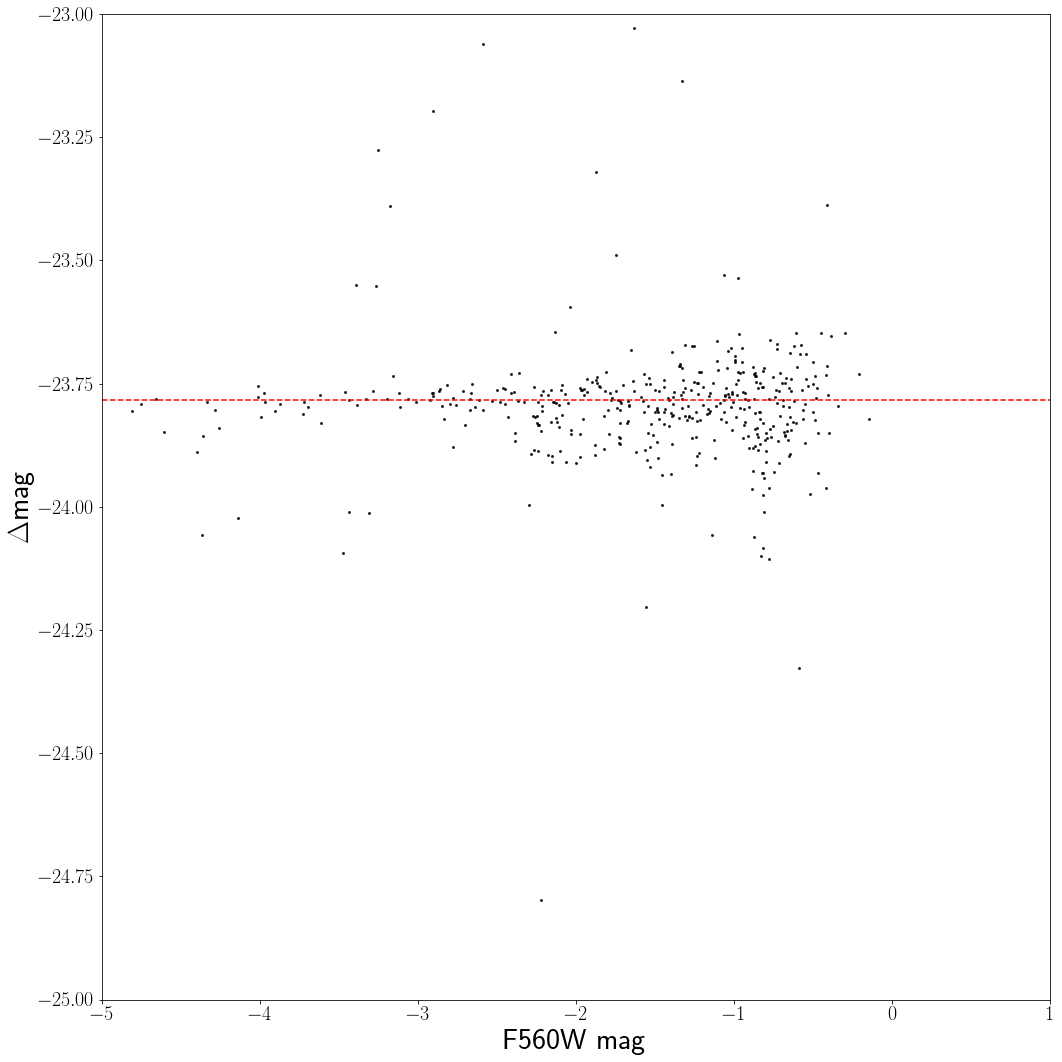

In [36]:
fig, ax = plt.subplots()
ax.scatter(phot_F560W_matched['mag_F560W'], phot_F560W_matched['mag_F560W']-calib_cat_F560W_matched['aper_total_abmag'], 
           lw=0.5, s=5, color='black', marker='o')
ax.set_xlim(-8+3, -2+3)
ax.set_ylim(-26+1, -24+1)
ax.axhline(mag_med_F560W, color='red', ls='--')
ax.set_xlabel(r'F560W mag')
ax.set_ylabel(r'$\Delta$mag')
plt.tight_layout()

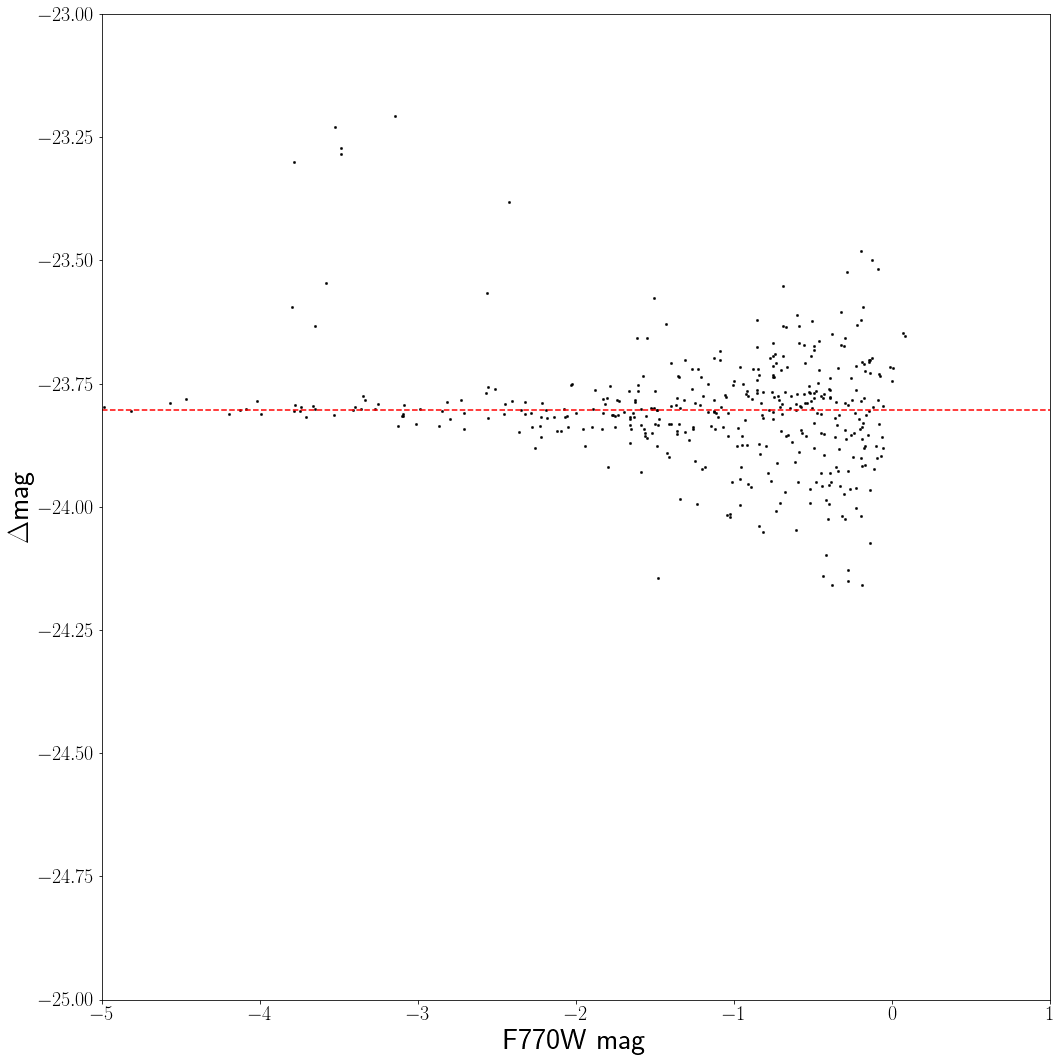

In [38]:
fig, ax = plt.subplots()
ax.scatter(phot_F770W_matched['mag_F770W'], phot_F770W_matched['mag_F770W']-calib_cat_F770W_matched['aper_total_abmag'], 
           lw=0.5, s=5, color='black', marker='o')
ax.set_xlim(-8+3, -2+3)
ax.set_ylim(-26+1, -24+1)
ax.axhline(mag_med_F770W, color='red', ls='--')
ax.set_xlabel(r'F770W mag')
ax.set_ylabel(r'$\Delta$mag')
plt.tight_layout()

Finally, the calibrate AB mag of our stars is simply:

In [39]:
match_phot_single['ABmag_F560W'] = match_phot_single['mag_F560W'] - mag_med_F560W
match_phot_single['ABmag_F770W'] = match_phot_single['mag_F770W'] - mag_med_F770W

The same procedure can be used to convert our instrumental magnitudes in the Vega system.

We have built two catalogs for the same field in two filters. We can combine the photometry in these catalogs to create our first mid-infrared color-magnitude diagram.

Let's check the result of the cross-match:

Finally, we can make our first mid-infrared color-magnitude diagram:

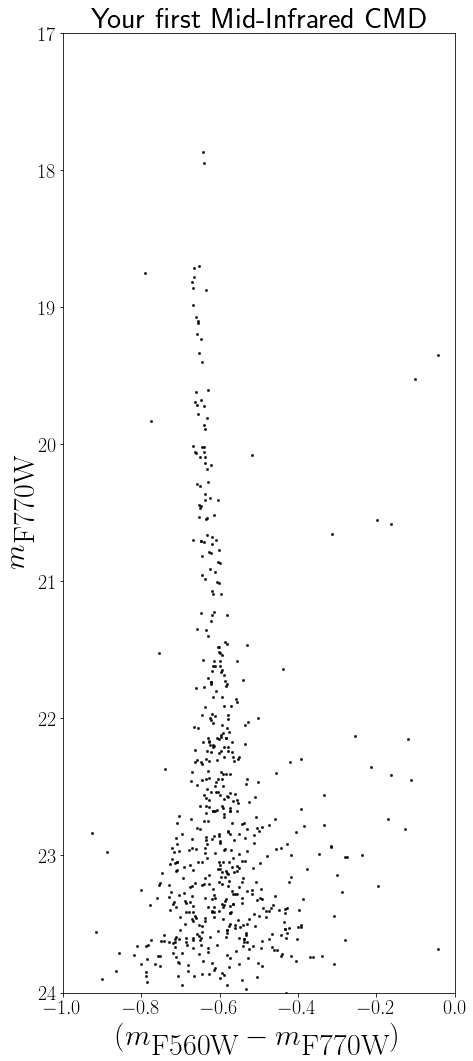

In [40]:
fig, ax = plt.subplots()
ax.set_aspect(0.35)
ax.scatter(match_phot_single['ABmag_F560W']-match_phot_single['ABmag_F770W'], 
           match_phot_single['ABmag_F770W'], lw=0.5, s=5, marker='o', color='black')
ax.set_xlim(-01.0, 0.0)
ax.set_ylim(24, 17)
ax.set_xlabel(r'$(m_{\textrm{F560W}}-m_{\textrm{F770W}})$')
ax.set_ylabel(r'$m_{\textrm{F770W}}$')
ax.set_title(r'Your first Mid-Infrared CMD')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect(0.35)
ax.scatter(match_phot_single['mag_F560W']-match_phot_single['mag_F770W'], 
           match_phot_single['mag_F770W'], lw=0.5, s=5, marker='o', color='black')
ax.set_xlim(-01.0+0.5, 0.02+0.5)
ax.set_ylim(24-35, 17-35)
ax.set_xlabel(r'$(m_{\textrm{F560W}}-m_{\textrm{F770W}})$')
ax.set_ylabel(r'$m_{\textrm{F770W}}$')
ax.set_title(r'The First MIRI CMD (LMC)')
plt.tight_layout()
#match_phot_single['mag_F560W']-match_phot_single['mag_F770W']
match_phot_single['mag_F770W']

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>